In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import var
import pandas as pd

Using plaidml.keras.backend backend.


In [2]:
def get_mobile_net(dim):

    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    # construct the head of the model that will be placed on top of the
    # the base model

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)

    model = Model(inputs=baseModel.input, outputs=headModel)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [3]:
def get_samples_norm(): 
    x_train = pickle.load(open(f'../Pickles/mobile_net_x_train.p', 'rb'))
    x_test = pickle.load(open(f'../Pickles/mobile_net_x_test.p', 'rb'))
    y_train = pickle.load(open(f'../Pickles/mobile_net_y_train.p', 'rb'))
    y_test = pickle.load(open(f'../Pickles/mobile_net_y_test.p', 'rb'))
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = get_samples_norm()

In [4]:
x_train.shape

(10317, 224, 224, 3)

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


augment = True 

early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=15, min_delta = .002)
model_checkpoint = ModelCheckpoint('../models/MobileNet-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')
epochs = 50
batch_size = 32
if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobile_net = get_mobile_net(dim =dim)

if augment: 
    augmentation =ImageDataGenerator(rotation_range = 15, width_shift_range = .1, height_shift_range = .1, 
                                                           horizontal_flip = True, fill_mode = 'nearest')
    augmentation.fit(x_train)
    mobile_net_history = mobile_net.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, steps_per_epoch = 8,
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)
else: 
    
    mobile_net_history = mobile_net.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/50


INFO:plaidml:Analyzing Ops: 989 of 1350 operations complete


8/8 [==============================] - 38s 5s/step - loss: 0.8187 - acc: 0.6641 - val_loss: 0.5792 - val_acc: 0.7477

Epoch 00001: val_loss improved from inf to 0.57921, saving model to ../models/MobileNet-ModelCheckpointWeights.h5
Epoch 2/50
8/8 [==============================] - 3s 357ms/step - loss: 0.4808 - acc: 0.7930 - val_loss: 1.3005 - val_acc: 0.6703

Epoch 00002: val_loss did not improve from 0.57921
Epoch 3/50
8/8 [==============================] - 3s 358ms/step - loss: 0.3862 - acc: 0.8477 - val_loss: 1.5269 - val_acc: 0.6703

Epoch 00003: val_loss did not improve from 0.57921
Epoch 4/50
8/8 [==============================] - 3s 360ms/step - loss: 0.2690 - acc: 0.9062 - val_loss: 1.3771 - val_acc: 0.6869

Epoch 00004: val_loss did not improve from 0.57921
Epoch 5/50
8/8 [==============================] - 3s 359ms/step - loss: 0.3788 - acc: 0.8594 - val_loss: 1.4043 - val_acc: 0.6869

Epoch 00005: val_loss did not improve from 0.57921
Epoch 6/50
8/8 [========================

In [6]:
print(mobile_net.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Loss and Accuracy

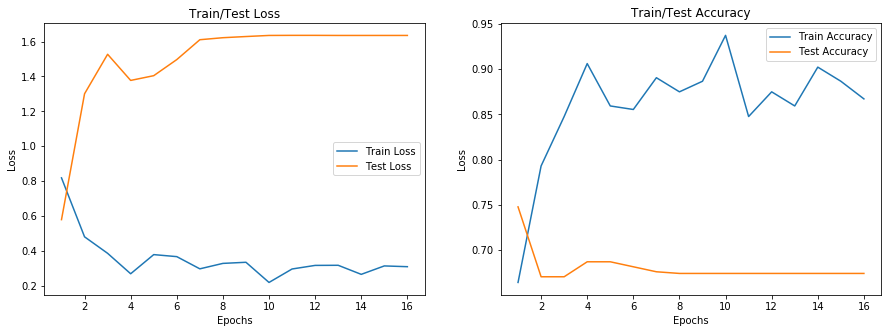

In [7]:
train_loss = mobile_net_history.history['loss']
train_acc = mobile_net_history.history['acc']
test_loss = mobile_net_history.history['val_loss']
test_acc = mobile_net_history.history['val_acc']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

### ROC and AUC

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


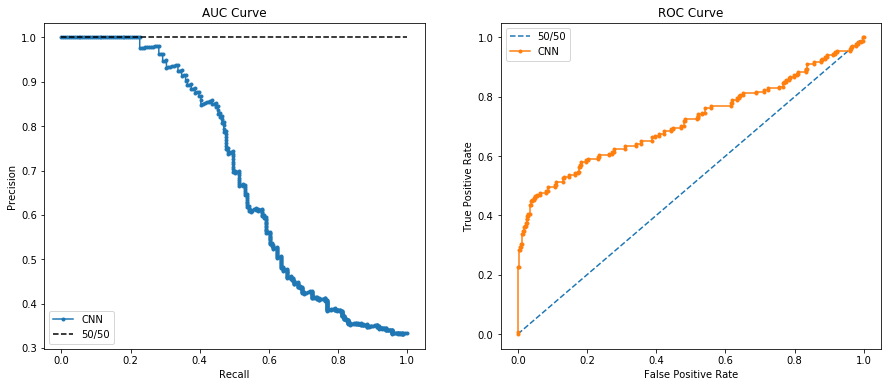

,F1 Score,AUC,ROC
0,0.396,0.692,0.717


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobilenet = get_mobile_net(dim)
mobilenet.load_weights('../models/MobileNet-ModelCheckpointWeights.h5') #load the best weights before overfitting
 

fig, ax = plt.subplots(1,2, figsize = (15,6))
#AUC CURVE
y_test_prob = mobilenet.predict(x_test)

y_test_precision, y_test_recall, spec = precision_recall_curve(y_test, y_test_prob)
y_test_predict = np.where(y_test_prob >= .5, 1, 0).ravel()
y_test_f1= f1_score(y_test, y_test_predict)
y_test_auc = auc(y_test_recall, y_test_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax[0].plot(y_test_recall, y_test_precision, marker='.', label='CNN')
ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='50/50', color = 'Black')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title(f'AUC Curve')
ax[0].legend()

#ROC CURVE
ns_probs = [0 for i in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
y_test_roc = roc_auc_score(y_test, y_test_prob)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
y_test_fpr, y_test_tpr, threshold = roc_curve(y_test, y_test_prob)
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='50/50')
ax[1].plot(y_test_fpr, y_test_tpr, marker='.', label='CNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title(f'ROC Curve')
ax[1].legend()
plt.show()

pd.DataFrame({'F1 Score': round(y_test_f1, 3), 'AUC': round(y_test_auc, 3), 'ROC':round(y_test_roc, 3)}, index = [0])

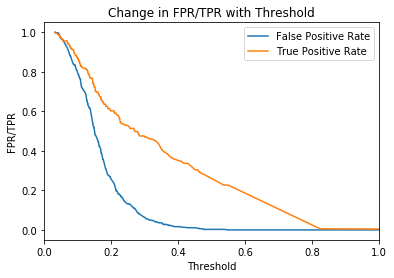

In [9]:
df = pd.DataFrame({'Threshold': threshold, 'FPR': y_test_fpr, 'TPR': y_test_tpr})
plt.plot(df.Threshold, df.FPR, label = 'False Positive Rate')
plt.plot(df.Threshold, df.TPR, label = 'True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('FPR/TPR')
plt.title('Change in FPR/TPR with Threshold')
plt.xlim(0, 1)
plt.legend()
plt.show()

### Confusion Matrix

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


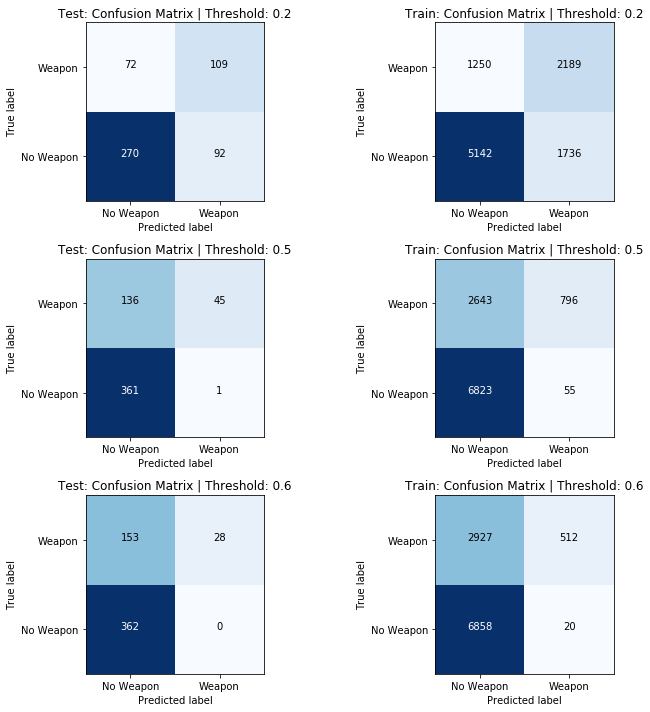

In [10]:
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_train, y_train_prob, y_test_prob,thresholds, classes,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(len(thresholds),2, figsize = (10,10))

    for idx, thresh in enumerate(thresholds):
        y_test_predict = np.where(y_test_prob >= thresh, 1, 0)
        y_train_predict = np.where(y_train_prob >= thresh, 1, 0)
        train_cm = confusion_matrix(y_train, y_train_predict) 
        test_cm = confusion_matrix(y_test, y_test_predict)
        
        #test confusion
        ax[idx, 0].imshow(test_cm,  cmap=plt.cm.Blues) 

        ax[idx, 0].set_title(f'Test: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 0].set_ylabel('True label')
        ax[idx, 0].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 0].set_xticks(tick_marks)
        ax[idx,0].set_xticklabels(class_names)
        ax[idx, 0].set_yticks(tick_marks)
        ax[idx, 0].set_yticklabels(class_names)

        th = test_cm.max() / 2. 

        for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
                ax[idx, 0].text(j, i, f'{test_cm[i, j]}',# | {int(round(test_cm[i,j]/test_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if test_cm[i, j] > th else 'black')
        ax[idx, 0].set_ylim([-.5,1.5])
        
        #TRAIN CONFUSION
        ax[idx, 1].imshow(train_cm,  cmap=plt.cm.Blues) 

        ax[idx, 1].set_title(f'Train: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 1].set_ylabel('True label')
        ax[idx, 1].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 1].set_xticks(tick_marks)
        ax[idx,1].set_xticklabels(class_names)
        ax[idx, 1].set_yticks(tick_marks)
        ax[idx, 1].set_yticklabels(class_names)


        th = train_cm.max() / 2. 

        for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
                ax[idx, 1].text(j, i, f'{train_cm[i, j]}',# | {int(round(train_cm[i,j]/train_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if train_cm[i, j] > th else 'black')
        ax[idx, 1].set_ylim([-.5,1.5])
    plt.tight_layout()
 
    plt.show()
if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobilenet = get_mobile_net(dim)
mobilenet.load_weights('../models/MobileNet-ModelCheckpointWeights.h5') #load the best weights before overfitting
 

y_test_prob = mobilenet.predict(x_test).ravel()

y_train_prob = mobilenet.predict(x_train).ravel()

plot_confusion_matrix(y_train = y_train, y_test = y_test, y_train_prob = y_train_prob,
                      y_test_prob = y_test_prob,classes = ['No Weapon', 'Weapon'], thresholds = [.2, .5,.6])

### Test on Google

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


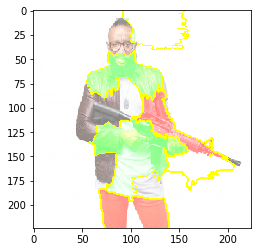

In [11]:
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries
import Functions as func

if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobilenet = get_mobile_net(dim)
mobilenet.load_weights('../models/MobileNet-ModelCheckpointWeights.h5') #load the best weights before overfitting
img = func.get_image_value('../test.jpg', var.mobilenet_dimension, var.img_type)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, mobilenet.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))

In [12]:
img = cv2.imread('../test3.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

windows = []
locations = []
for x, y, w,h in rects: 
    startx = x 
    starty = y 
    endx = x+w 
    endy = y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize =var.mobilenet_dimension, interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))

    
windows = np.array(windows)

predictions = mobilenet.predict(windows)

In [24]:
clone = img.copy()
new_loc = [] 
new_prob = [] 
for idx, i in enumerate(predictions): 
    if i < .7: 
        continue
    startx, starty, endx, endy = locations[idx]
    cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
    text = f'Weapon: {i*100}'
    cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
    new_loc.append(locations[idx])
    new_prob.append(i[0])
    
cv2.imshow('test', clone)
cv2.waitKey(0)

-1

In [23]:
test = np.array(new_prob).ravel()
print(np.argmax(test), test.max())

748 0.7457963


In [21]:
boxids = func.non_max_suppression(np.array(new_loc), np.array(new_prob))[0]
clone = img.copy()
  
startx, starty, endx, endy = new_loc[748]
cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
text = f'Weapon: {i*100}'
cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
cv2.imshow('test', clone)
cv2.waitKey(0)

-1